In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Softmax, Sigmoid, Module
from scipy.optimize import minimize
from IPython.display import clear_output

In [2]:
# Creating/Formatting Data

In [3]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-10 18:23:15.624848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733883795.637665   18190 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733883795.641402   18190 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 18:23:15.654167: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [4]:
# Filter Values
a = 3
b = 4
c = 5
d = 6
def filter_abcd(x, y):
    keep = (y == a) | (y == b) | (y == c) | (y == d)
    x, y = x[keep], y[keep]
    return x,y

In [5]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 23312
Number of filtered test examples: 3842


6


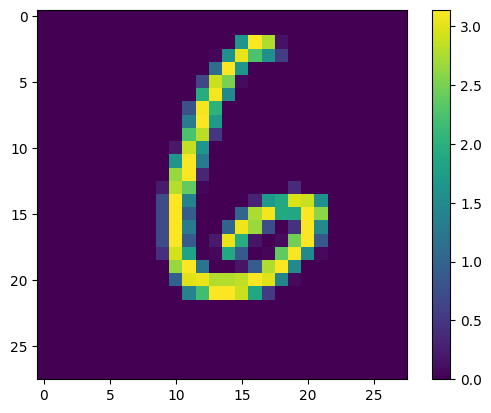

In [6]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [7]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1733883798.372846   18190 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


6


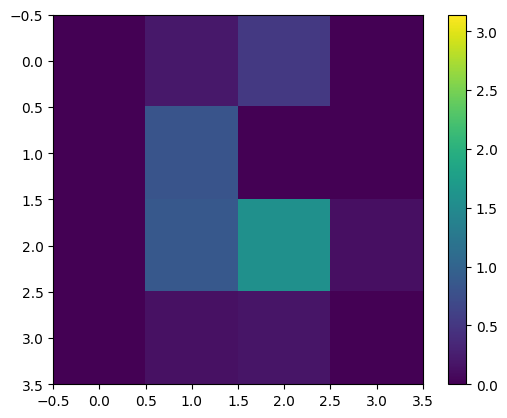

In [8]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [9]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
        elif entry == c:
            y_temp.append(2)
        elif entry == d:
            y_temp.append(3)
    return y_temp

In [10]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:128]
y = y[0:128]
x1 = x1[0:128]
y1 = y1[0:128]
print(x)
print(y)

[[0.         0.19058241 0.5850729  ... 1.2083628  0.15663964 0.        ]
 [0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 ...
 [0.         0.21999948 1.2091172  ... 0.9302835  0.07215983 0.        ]
 [0.         0.00553142 0.68262696 ... 0.99364346 0.57375866 0.        ]
 [0.         0.         0.17826243 ... 0.16342819 0.2768222  0.        ]]
[2 1 0 1 0 2 0 3 3 1 1 0 0 3 2 3 3 0 2 0 0 1 1 1 1 3 1 2 3 3 0 3 0 1 3 1 3
 0 2 3 0 0 1 3 1 3 0 1 2 0 0 2 1 1 2 3 0 1 3 3 0 1 1 3 1 2 2 0 0 2 3 2 1 0
 0 3 0 0 1 3 2 3 1 0 0 2 1 3 2 3 0 2 0 0 0 3 1 2 3 2 1 1 2 3 1 2 0 0 2 3 2
 1 0 1 1 1 0 3 3 2 3 1 2 0 3 0 2 1]


In [11]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    countc = 0
    countd = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
        elif y[i] == 2:
            countc+=1
        elif y[i] == 3:
            countd+=1
    return(counta, countb, countc, countd)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
        elif y[i] == 2:
            if count2 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count2 += 1
        elif y[i] == 3:
            if count3 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count3 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [12]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (36, 34, 26, 32)
max_count = 26
balanced: (26, 26, 26, 26)
shuffled: (26, 26, 26, 26)
final: [[0.0000000e+00 1.7675388e-01 1.1231288e+00 ... 1.1764315e+00
  1.8655956e-01 0.0000000e+00]
 [0.0000000e+00 2.7355364e-01 4.5609033e-01 ... 1.7474245e-01
  4.0454763e-01 0.0000000e+00]
 [1.4331395e-02 6.6703850e-01 7.6333541e-01 ... 1.0394033e+00
  9.4285488e-01 0.0000000e+00]
 ...
 [9.8056914e-03 4.9078742e-01 7.0173550e-01 ... 1.6810473e+00
  8.6365509e-01 0.0000000e+00]
 [0.0000000e+00 5.0285592e-04 2.7053651e-01 ... 0.0000000e+00
  6.5446705e-01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.5138159e-01
  0.0000000e+00 0.0000000e+00]]
[0 3 0 0 1 1 2 3 2 1 2 3 2 0 2 0 0 1 2 1 0 3 3 0 1 3 2 0 0 3 3 3 0 3 1 1 1
 3 1 3 3 0 0 1 2 3 2 0 2 1 0 1 3 2 2 2 1 0 2 3 0 1 2 3 3 1 1 3 1 1 3 3 2 1
 0 1 0 2 2 0 1 1 0 0 0 2 2 3 1 2 0 2 1 3 2 0 2 2 3 3 3 0 2 1]


In [13]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [14]:
# One-Hot Encoding for Final Processing
num_classes = 4
Y = (torch.nn.functional.one_hot(Y, num_classes=num_classes).float())
Y1 = (torch.nn.functional.one_hot(Y1, num_classes=num_classes).float())

In [15]:
print(X,Y,X1,Y1)

tensor([[0.0000e+00, 1.7675e-01, 1.1231e+00,  ..., 1.1764e+00, 1.8656e-01,
         0.0000e+00],
        [0.0000e+00, 2.7355e-01, 4.5609e-01,  ..., 1.7474e-01, 4.0455e-01,
         0.0000e+00],
        [1.4331e-02, 6.6704e-01, 7.6334e-01,  ..., 1.0394e+00, 9.4285e-01,
         0.0000e+00],
        ...,
        [9.8057e-03, 4.9079e-01, 7.0174e-01,  ..., 1.6810e+00, 8.6366e-01,
         0.0000e+00],
        [0.0000e+00, 5.0286e-04, 2.7054e-01,  ..., 0.0000e+00, 6.5447e-01,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.5138e-01, 0.0000e+00,
         0.0000e+00]], device='cuda:0') tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.

In [16]:
# Training

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class OneHotCNN(nn.Module):
    def __init__(self, input_length=16, num_classes=4):
        super(OneHotCNN, self).__init__()

        self.input_length = input_length
        self.num_classes = num_classes

        # Convolutional Layer 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, padding=1)
        # Output shape: (batch_size, 2, 16)

        # Max Pooling Layer 1
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        # Output shape: (batch_size, 2, 8)

        # Convolutional Layer 2
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=3, padding=1)
        # Output shape: (batch_size, 4, 8)

        # Max Pooling Layer 2
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        # Output shape: (batch_size, 4, 4)

        # Fully Connected Layer 1
        self.fc1 = nn.Linear(4 * 4, 8)
        # Output shape: (batch_size, 8)

        # Fully Connected Layer 2 (Output Layer)
        self.fc2 = nn.Linear(8, num_classes)
        # Output shape: (batch_size, num_classes)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Reshape the input to have a channel dimension
        x = x.unsqueeze(1) # Output shape: (batch_size, 1, 16)

        # Convolutional Layer 1 with ReLU activation
        x = F.relu(self.conv1(x))
        # Output shape: (batch_size, 2, 16)

        # Max Pooling Layer 1
        x = self.pool1(x)
        # Output shape: (batch_size, 2, 8)

        # Convolutional Layer 2 with ReLU activation
        x = F.relu(self.conv2(x))
        # Output shape: (batch_size, 4, 8)

        # Max Pooling Layer 2
        x = self.pool2(x)
        # Output shape: (batch_size, 4, 4)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 4 * 4)  # Reshape to (batch_size, 4 * 4)

        # Fully Connected Layer 1 with ReLU activation
        x = F.relu(self.fc1(x))
        # Output shape: (batch_size, 8)

        # Fully Connected Layer 2 (Output Layer)
        x = self.fc2(x)
        # Output shape: (batch_size, num_classes)

        x = self.softmax(x)

        # No need to apply softmax here if using CrossEntropyLoss later (it does it implicitly)
        return x

# Example usage:
# Create an instance of the model
model = OneHotCNN()
# Example usage:
# Create an instance of the model
model = OneHotCNN()

In [28]:
model.to("cuda")
next(model.parameters()).is_cuda

True

In [30]:
model(X[:10])

tensor([[0.2507, 0.2590, 0.2806, 0.2097],
        [0.2499, 0.2601, 0.2811, 0.2089],
        [0.2501, 0.2609, 0.2796, 0.2094],
        [0.2508, 0.2595, 0.2797, 0.2100],
        [0.2499, 0.2604, 0.2809, 0.2087],
        [0.2497, 0.2600, 0.2814, 0.2089],
        [0.2498, 0.2595, 0.2817, 0.2090],
        [0.2499, 0.2602, 0.2808, 0.2091],
        [0.2497, 0.2601, 0.2814, 0.2088],
        [0.2501, 0.2604, 0.2809, 0.2085]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [31]:
# We want to supply one-hot encoded labels.
from tensorflow.keras.losses import CategoricalCrossentropy
loss_func = CategoricalCrossentropy()

# Callback Helper Functions
def accuracy(output, Y):
    acc = 0
    for i in range(Y.size(dim=0)):
        val = output[i]
        if (torch.argmax(val) == torch.argmax(Y[i])):
            acc+=1
    return ((acc/(Y.size(dim=0)))*100)

def objective_function(weights):
    global X
    global Y
    if(i != 1 and i%333 == 0):
        indices = torch.randperm(X.size()[0])
        X=X[indices]
        Y=Y[indices]
        print(X,Y)
    # Referencing Global Variables
    global data
    # Local Variable
    total_loss = 0.0
    # Overiding with new data
    with torch.no_grad():
        # Convolutional Layer 1
        model.conv1.weight = nn.Parameter(torch.tensor(weights[:6], dtype=torch.float32, device="cuda").reshape(2, 1, 3))
        # Notation: (out_channels, in_channels, kernel_size) = (2, 1, 3)
        model.conv1.bias = nn.Parameter(torch.tensor(weights[6:8], dtype=torch.float32, device="cuda").reshape(2))

        # Convolutional Layer 2
        model.conv2.weight = nn.Parameter(torch.tensor(weights[8:32], dtype=torch.float32, device="cuda").reshape(4, 2, 3))
        # Notation: (out_channels, in_channels, kernel_size) = (4, 2, 3)
        model.conv2.bias = nn.Parameter(torch.tensor(weights[32:36], dtype=torch.float32, device="cuda").reshape(4))

        # Fully Connected Layer 1
        model.fc1.weight = nn.Parameter(torch.tensor(weights[36:164], dtype=torch.float32, device="cuda").reshape(8, 16))
        model.fc1.bias = nn.Parameter(torch.tensor(weights[164:172], dtype=torch.float32, device="cuda").reshape(8))

        # Fully Connected Layer 2 (Output Layer)
        model.fc2.weight = nn.Parameter(torch.tensor(weights[172:204], dtype=torch.float32, device="cuda").reshape(4, 8))
        model.fc2.bias = nn.Parameter(torch.tensor(weights[204:208], dtype=torch.float32, device="cuda").reshape(4))

    # Getting Output
    output = model(X)
    loss_output = output.detach().cpu().numpy()
    loss_Y = Y.detach().cpu().numpy()
    # Calculate Loss
    loss = loss_func(loss_output, loss_Y).numpy()
    # Append Checkpoint Data Points to Tracker
    val = f"Iteration: {i}; Accuracy: {accuracy(output, Y)}%; Loss: {loss}"
    data.append(val)
    total_loss += loss
    loss_list.append(total_loss)
    return total_loss

def callback(weights):
    # Iteration Tracking
    global i
    global weight_list
    # Printing Checkpoint Data Points in Tracker
    print("\n".join(data))
    # Plotting Loss Function
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(loss_list)), loss_list)
    # plt.show()
    # Printing Weights
    weight_list.append(weights)
    print(weights)
    # Iteration Counter
    i+=1
    # Clearing Previous Graph/Weights
    clear_output(wait=True)

In [32]:
# Training Function
from qiskit_machine_learning.utils import algorithm_globals
algorithm_globals.random_seed = 65
def fit(weights=None, losslist=None, iter= 1000, fresh_start = False):
    global i
    global data
    global weight_list
    global loss_list
    if(fresh_start):
        loss_list = []
        data = []
        weight_list = []
        weights = algorithm_globals.random.random(10148)
        i = 1
    else:
        if 'data' not in globals(): data = []
        else: data = data
        if 'weight_list' not in globals():weight_list = []
        else: weight_list = weight_list
        if 'i' not in globals() and 'i' not in locals(): i = 1
        else: i = i
        if losslist is not None: losslist = losslist
        elif (('loss_list' not in globals() and 'loss_list' not in locals()) and losslist == None): loss_list = []
        elif 'loss_list' not in globals() and 'loss_list' not in locals(): loss_list = losslist
        else: loss_list = loss_list
        if weights is not None: weights = weights
        elif (('result' not in locals() and 'result' not in globals())) and weights == None:
            weights = algorithm_globals.random.random(10148)
        elif (len(weight_list)>0):
            weights = weight_list[-1]
        else:
            weights = result[0].x
            loss_list = result[2]
    
    result = minimize(
        fun=objective_function,
        callback = callback,
        x0=weights,
        method='COBYLA',
        options={'maxiter': iter},
    )
    return result, data, loss_list, weight_list

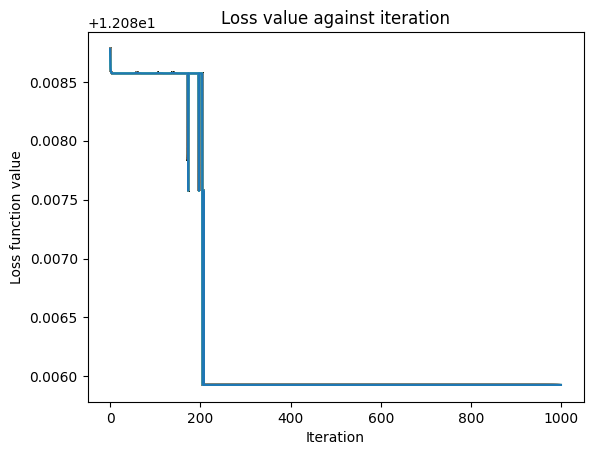

In [33]:
# Call Training Function and Save as Result
result = fit(iter=1000, fresh_start=False)

In [36]:
savemodel = OneHotCNN()
with torch.no_grad():
        # Convolutional Layer 1
        savemodel.conv1.weight = nn.Parameter(torch.tensor(result[0].x[:6], dtype=torch.float32, device="cuda").reshape(2, 1, 3))
        # Notation: (out_channels, in_channels, kernel_size) = (2, 1, 3)
        savemodel.conv1.bias = nn.Parameter(torch.tensor(result[0].x[6:8], dtype=torch.float32, device="cuda").reshape(2))

        # Convolutional Layer 2
        savemodel.conv2.weight = nn.Parameter(torch.tensor(result[0].x[8:32], dtype=torch.float32, device="cuda").reshape(4, 2, 3))
        # Notation: (out_channels, in_channels, kernel_size) = (4, 2, 3)
        savemodel.conv2.bias = nn.Parameter(torch.tensor(result[0].x[32:36], dtype=torch.float32, device="cuda").reshape(4))

        # Fully Connected Layer 1
        savemodel.fc1.weight = nn.Parameter(torch.tensor(result[0].x[36:164], dtype=torch.float32, device="cuda").reshape(8, 16))
        savemodel.fc1.bias = nn.Parameter(torch.tensor(result[0].x[164:172], dtype=torch.float32, device="cuda").reshape(8))

        # Fully Connected Layer 2 (Output Layer)
        savemodel.fc2.weight = nn.Parameter(torch.tensor(result[0].x[172:204], dtype=torch.float32, device="cuda").reshape(4, 8))
        savemodel.fc2.bias = nn.Parameter(torch.tensor(result[0].x[204:208], dtype=torch.float32, device="cuda").reshape(4))
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "4Classes_Circuit2Ab")

True


In [37]:
evalmodel = torch.load("4Classes_Circuit2Ab", weights_only=False).to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 25.0%
Test Accuracy: 25.0%


In [38]:
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2,

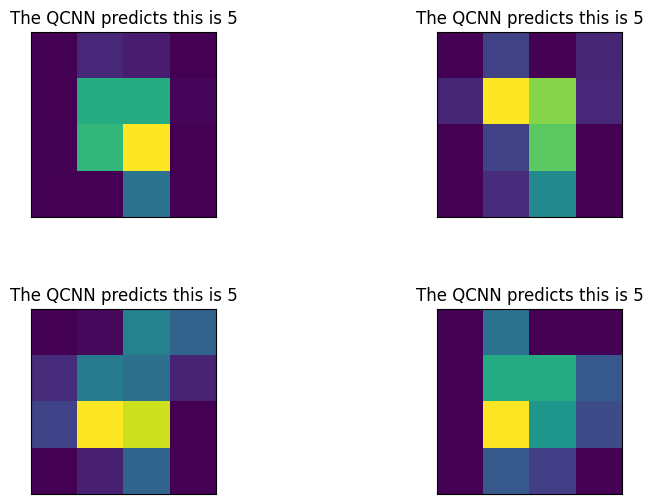

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X1.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    if torch.argmax(output1[i]) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if torch.argmax(output1[i]) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
    if torch.argmax(output1[i]) == 2:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 5")
    if torch.argmax(output1[i]) == 3:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 6")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

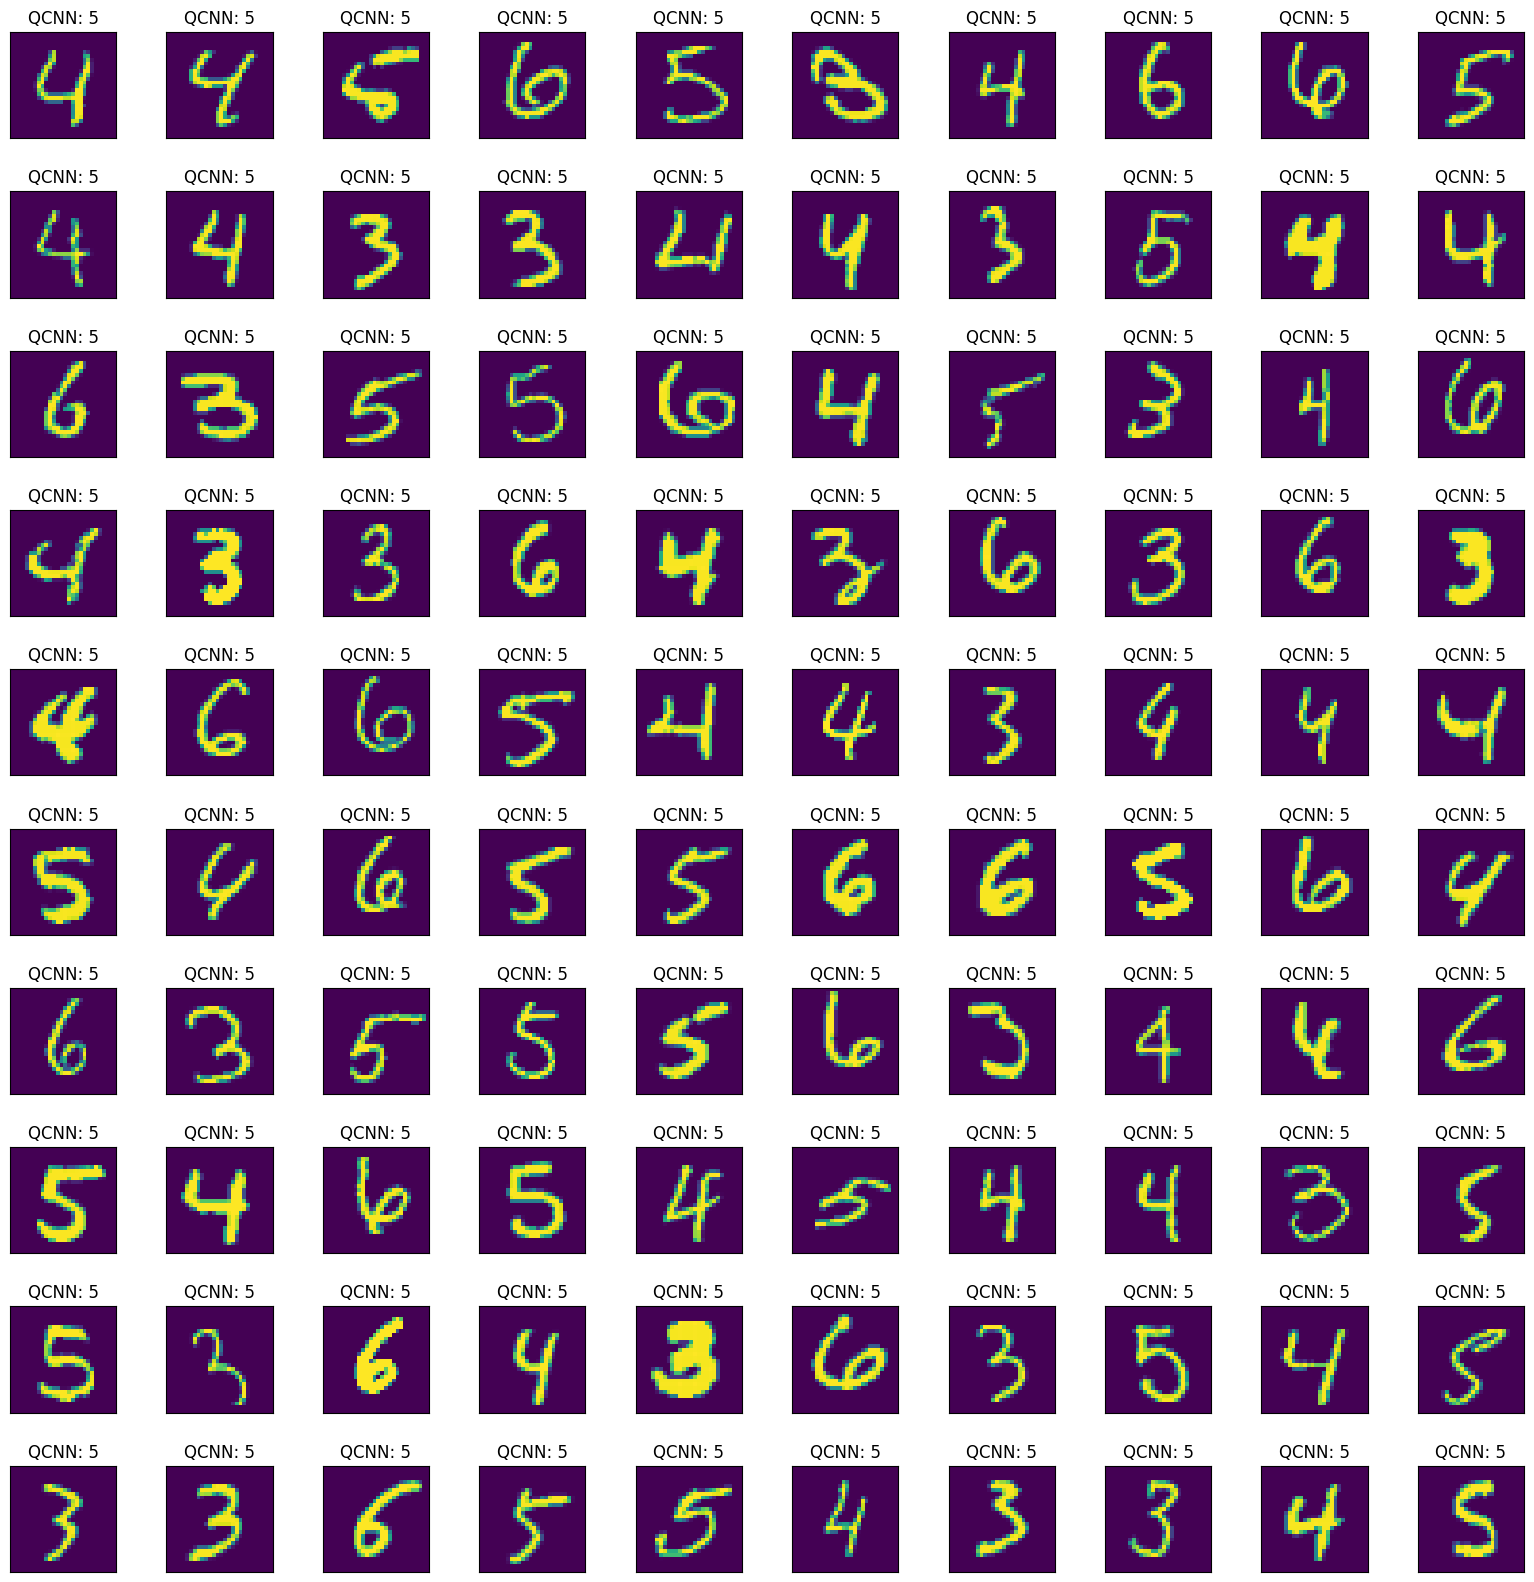

In [40]:
num_rows = 10
num_cols = 10
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 20),
                       subplot_kw={"xticks": [], "yticks": []})

for i in range(num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    
    if i < len(x_test) and i < len(output1):
      ax[row, col].imshow(x_test[i].reshape(28, 28), aspect="equal")

      if torch.argmax(output1[i]) == 0:
          ax[row, col].set_title("QCNN: 3")
      elif torch.argmax(output1[i]) == 1:
          ax[row, col].set_title("QCNN: 4")
      elif torch.argmax(output1[i]) == 2:
          ax[row, col].set_title("QCNN: 5")
      elif torch.argmax(output1[i]) == 3:
          ax[row, col].set_title("QCNN: 6")
    else:
        ax[row, col].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

In [ ]:
print(result)

( message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 11.438172340393066
       x: [-4.857e-01  9.846e-01 ...  1.134e-01  4.098e-01]
    nfev: 1000
   maxcv: 0.0, ['Iteration: 1; Accuracy: 26.923076923076923%; Loss: 12.037858009338379', 'Iteration: 2; Accuracy: 26.923076923076923%; Loss: 12.060754776000977', 'Iteration: 3; Accuracy: 26.923076923076923%; Loss: 12.060887336730957', 'Iteration: 4; Accuracy: 26.923076923076923%; Loss: 12.037858009338379', 'Iteration: 5; Accuracy: 24.03846153846154%; Loss: 12.067124366760254', 'Iteration: 6; Accuracy: 23.076923076923077%; Loss: 12.055484771728516', 'Iteration: 7; Accuracy: 26.923076923076923%; Loss: 12.037858009338379', 'Iteration: 8; Accuracy: 22.115384615384613%; Loss: 12.06893539428711', 'Iteration: 9; Accuracy: 24.03846153846154%; Loss: 12.059345245361328', 'Iteration: 10; Accuracy: 26.923076923076923%; Loss: 12.037858009338379', 'Iteration: 11; Accuracy: 27.884615384615387%; Loss: 12

In [ ]:
# Iteration Value Display Error (Skips back to 3)
result[1]

['Iteration: 1; Accuracy: 26.923076923076923%; Loss: 12.037858009338379',
 'Iteration: 2; Accuracy: 26.923076923076923%; Loss: 12.060754776000977',
 'Iteration: 3; Accuracy: 26.923076923076923%; Loss: 12.060887336730957',
 'Iteration: 4; Accuracy: 26.923076923076923%; Loss: 12.037858009338379',
 'Iteration: 5; Accuracy: 24.03846153846154%; Loss: 12.067124366760254',
 'Iteration: 6; Accuracy: 23.076923076923077%; Loss: 12.055484771728516',
 'Iteration: 7; Accuracy: 26.923076923076923%; Loss: 12.037858009338379',
 'Iteration: 8; Accuracy: 22.115384615384613%; Loss: 12.06893539428711',
 'Iteration: 9; Accuracy: 24.03846153846154%; Loss: 12.059345245361328',
 'Iteration: 10; Accuracy: 26.923076923076923%; Loss: 12.037858009338379',
 'Iteration: 11; Accuracy: 27.884615384615387%; Loss: 12.031133651733398',
 'Iteration: 12; Accuracy: 26.923076923076923%; Loss: 12.03448486328125',
 'Iteration: 13; Accuracy: 27.884615384615387%; Loss: 12.031133651733398',
 'Iteration: 14; Accuracy: 32.69230769